# 加载谷歌云

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

In [ ]:
mkdir /root/.kaggle/

In [ ]:
mv /content/kaggle.json /root/.kaggle/

In [ ]:
! unzip /content/lgg-mri-segmentation.zip

# 加载包

In [ ]:
import pandas as pd
from torch import optim
import os
import matplotlib.pyplot as plt 
import cv2 
from glob import glob
from torch.autograd import Variable
import torch.nn.functional as F
import torch as t
import numpy as np
import torchvision.transforms.functional as ff
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 加载Dataset

## 生成pandas格式的列表

In [ ]:
# 数据集路径
# data_dir = "/content/kaggle_3m"   
data_dir = "../input/lgg-mri-segmentation/kaggle_3m"

# 生成mask和img的路径地址array
images_dir = []
masks_dir = []
masks_dir = glob(data_dir + '/*/*_mask*')

for i in masks_dir:
    images_dir.append(i.replace('_mask',''))

print("image的长度{}, image前两张{}".format(len(images_dir), images_dir[:2]))
print("mask的长度{}, mask前两张{}".format(len(masks_dir), masks_dir[:2]))

image的长度3929, image前两张['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif']
mask的长度3929, mask前两张['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif']


In [ ]:
data = pd.DataFrame({'images':images_dir,'masks':masks_dir})
data

,images,masks
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
...,...,...
3924,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3925,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3926,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3927,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...


## 可视化

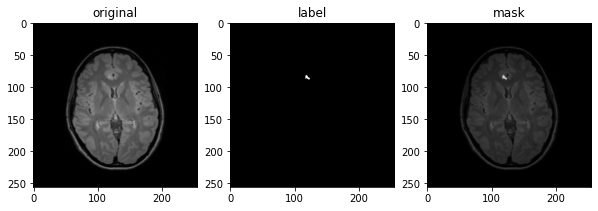

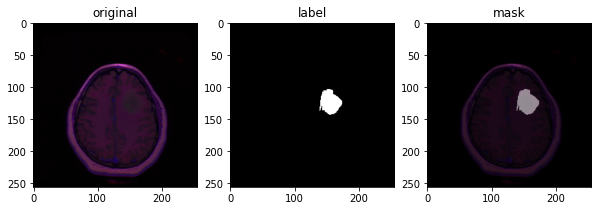

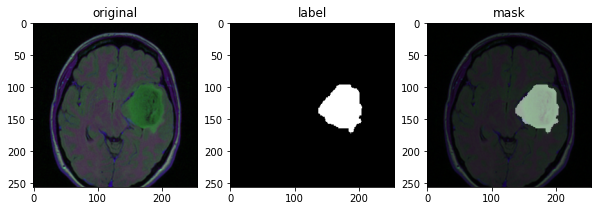

In [ ]:
# 可视化第
pic_list=[265,895,95]
for N in pic_list:
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    img = cv2.imread(data.images.iloc[N])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("original")
    plt.imshow(img)
    plt.subplot(1,3,2)
    msk=cv2.imread(data.masks.iloc[N])
    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
    plt.title("label")
    plt.imshow(msk)
    plt.subplot(1,3,3)
    plt.title("mask")
    plt.imshow(img)
    plt.imshow(msk,alpha=0.5)

In [ ]:
a = cv2.imread(data.masks.iloc[95])
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

In [ ]:
print(a.shape)

(256, 256, 3)


In [ ]:
# 查看值得分布
msk=cv2.imread(data.masks.iloc[95])
print(msk.shape)
print(np.unique(msk))

(256, 256, 3)
[  0 255]


## 对label编码

In [ ]:
class LabelProcessor:
    """对标签图像的编码, 生成1通道的每个像素是类别的array"""

    def __init__(self):
        self.colormap = self.read_color_map()
        self.cm2lbl = self.encode_label_pix(self.colormap)
    
    # 标签编码，返回 1通道 的 已编码的标签 eg: [0000000][0011000][0000000]
    def encode_label_img(self, img):
        data = np.array(img, dtype='int32')
        idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
        return np.array(self.cm2lbl[idx], dtype='int64')
    
    # 加载color map, eg: 第0个->黑色, 第1个->白色
    @staticmethod
    def read_color_map():  
        colormap = []
        colormap.append([0,0,0])
        colormap.append([255,255,255])
        return colormap
    
    # 标签编码，返回哈希表 eg: cm2lbl[0] = 0, cm2lbl[(255*256+255)*256+256] = 1
    @staticmethod
    def encode_label_pix(colormap):     
        cm2lbl = np.zeros(256 ** 3)
        for i, cm in enumerate(colormap):
            cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
        return cm2lbl

## 构建pytorch dataset

In [ ]:
class MRIDataset(Dataset):
    """传入pandas格式 eg: img_path = pandas["image"]"""
    
    def __init__(self, img_path, label_path):
        # 读入图片和标签路径, 传入pandas格式 eg: img_path = pandas["image"]
        if not isinstance(img_path, np.ndarray):
            self.img_path = img_path.to_numpy()
            self.label_path = label_path.to_numpy()
        self.labelProcessor = LabelProcessor()

    def __getitem__(self, index):
        img = self.img_path[index]
        label = self.label_path[index]
        # 从文件名中读取数据（图片和标签都是png格式的图像数据）
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = cv2.imread(label)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        # transform
        img, label = self.img_transform(img, label)

        return {'img': img, 'label': label}

    def __len__(self):
        return len(self.img_path)

    def img_transform(self, img, label):
        # 对图片和标签做一些数值处理
        transform_img = transforms.Compose([transforms.ToTensor(),  # 转tensor
                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        img = transform_img(img)
        label = self.labelProcessor.encode_label_img(label)
        label = t.from_numpy(label)

        return img, label

In [ ]:
a = MRIDataset(data["images"], data["masks"])
a[0]["img"].shape

torch.Size([3, 256, 256])

# FCN

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import numpy as np
import torch
from torchvision import models
from torch import nn


class FCN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        pretrained_net = models.vgg16_bn(pretrained=True)
        self.stage1 = pretrained_net.features[:7]
        self.stage2 = pretrained_net.features[7:14]
        self.stage3 = pretrained_net.features[14:24]
        self.stage4 = pretrained_net.features[24:34]
        self.stage5 = pretrained_net.features[34:]

        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(512, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)

        self.conv_trans1 = nn.Conv2d(512, 256, 1)
        self.conv_trans2 = nn.Conv2d(256, num_classes, 1)

        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        # self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16)

        self.upsample_2x_1 = nn.ConvTranspose2d(512, 512, 4, 2, 1, bias=False)
        # self.upsample_2x_1.weight.data = bilinear_kernel(512, 512, 4)

        self.upsample_2x_2 = nn.ConvTranspose2d(256, 256, 4, 2, 1, bias=False)
        # self.upsample_2x_2.weight.data = bilinear_kernel(256, 256, 4)

    def forward(self, x):
        s1 = self.stage1(x)
        s2 = self.stage2(s1)
        s3 = self.stage3(s2)
        s4 = self.stage4(s3)
        s5 = self.stage5(s4)

        scores1 = self.scores1(s5)
        s5 = self.upsample_2x_1(s5)
        add1 = s5 + s4

        scores2 = self.scores2(add1)

        add1 = self.conv_trans1(add1)
        add1 = self.upsample_2x_2(add1)
        add2 = add1 + s3

        output = self.conv_trans2(add2)
        output = self.upsample_8x(output)
        return output


if __name__ == "__main__":
    import torch as t
    print('-----'*5)
    rgb = t.randn(1, 3, 32, 32)

    net = FCN(2)

    out = net(rgb)

    print(out.shape)

-------------------------


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

torch.Size([1, 2, 32, 32])


# evaluation

In [ ]:
from __future__ import division
from sklearn.metrics import confusion_matrix
import numpy as np
import six


def calc_semantic_segmentation_confusion(pred_labels, gt_labels):
    pred_labels = pred_labels.flatten()
    gt_labels = gt_labels.flatten()
    confusion = confusion_matrix(gt_labels, pred_labels)
    return confusion


def calc_semantic_segmentation_iou(confusion):
    iou_denominator = (confusion.sum(axis=1) + confusion.sum(axis=0) - np.diag(confusion))
    iou = np.diag(confusion) / iou_denominator
    return iou


def eval_semantic_segmentation(pred_labels, gt_labels):

    confusion = calc_semantic_segmentation_confusion(pred_labels, gt_labels)
    iou = calc_semantic_segmentation_iou(confusion) 
    pixel_accuracy = np.diag(confusion).sum() / confusion.sum()
    class_accuracy = np.diag(confusion) / (np.sum(confusion, axis=1) + 1e-10)
    dice = 2*np.nanmean(iou) / (1 + np.nanmean(iou))

    return {'iou': iou, 
            'miou': np.nanmean(iou),
            'pixel_accuracy': pixel_accuracy,
            'class_accuracy': class_accuracy,
            'mean_class_accuracy': np.nanmean(class_accuracy),
            'dice': dice}

In [ ]:
rgb = t.randn(1, 3, 64, 64)
net = FCN(2)
out = net(rgb)
print(out.shape)

torch.Size([1, 2, 64, 64])


In [ ]:
out = F.log_softmax(out, dim=1)
out = out.max(dim=1)[1].data.cpu().numpy()
true_label = torch.randint(0,2,(1,64,64)).numpy()

In [ ]:
eval_semantic_segmentation(out,true_label)

{'iou': array([0.30876959, 0.34605678]),
 'miou': 0.3274131860988363,
 'pixel_accuracy': 0.493896484375,
 'class_accuracy': array([0.45369917, 0.53381995]),
 'mean_class_accuracy': 0.49375955920655723,
 'dice': 0.49331013060233053}

# train

In [ ]:
# 测试训练分割

from sklearn.model_selection import train_test_split
train, test = train_test_split(data,test_size=0.2, shuffle=True)

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
num_class = 2

Load_train = MRIDataset(train["images"], train["masks"])
Load_val= MRIDataset(test["images"], test["masks"])

train_data = DataLoader(Load_train, batch_size=4, shuffle=True, num_workers=1)
val_data = DataLoader(Load_val, batch_size=4, shuffle=True, num_workers=1)

In [ ]:
fcn = FCN(num_class)
fcn = fcn.to(device)
criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(fcn.parameters(), lr=1e-4)

In [ ]:
net = fcn.train()

best = [0]
Epoch = 20
train_loss_epoch = []
train_acc_epoch = []
train_miou_epoch = []
train_dice_epoch = []
train_class_acc_epoch = []

# 训练轮次
for epoch in range(Epoch):

    train_loss = 0
    train_acc = 0
    train_miou = 0
    train_dice = 0
    train_class_acc = 0
    error = 0
    print('Epoch is [{}/{}]'.format(epoch + 1, Epoch))

    # 训练批次
    for i, sample in enumerate(train_data):
        # 载入数据
        img_data = sample['img'].to(device)
        img_label = sample['label'].to(device)
        # 训练
        out = net(img_data)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, img_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # 评估
        pre_label = out.max(dim=1)[1].data.cpu().numpy()
        true_label = img_label.data.cpu().numpy()
        eval_metrix = eval_semantic_segmentation(pre_label, true_label)
        train_acc += eval_metrix['mean_class_accuracy']
        train_miou += eval_metrix['miou']
        if len(eval_metrix['class_accuracy']) < num_class:
            eval_metrix['class_accuracy'] = 0
            train_class_acc = train_class_acc + eval_metrix['class_accuracy']
            error += 1
        else:
            train_class_acc = train_class_acc + eval_metrix['class_accuracy']
        train_dice += eval_metrix['dice']
        # 打印每50次
        if i%100 ==0:
            print('|batch[{}/{}]|batch_loss:{:.9f}|'.format(i + 1, len(train_data), loss.item()))

    metric_description = '|Train Acc|: {:.5f}\n|Train dice|: {:.5f}\n|Train Mean IoU|: {:.5f}\n|Train_class_acc|: {:}'.format(
        train_acc / len(train_data),
        train_dice / len(train_data),
        train_miou / len(train_data),
        train_class_acc / (len(train_data)-error))

    print("-----------------")
    print(metric_description )
    print("-----------------")

    train_loss_epoch.append(loss.item())
    train_acc_epoch.append(train_acc / len(train_data))
    train_miou_epoch.append(train_miou / len(train_data))
    train_dice_epoch.append(train_dice / len(train_data))
    train_class_acc_epoch.append(list(train_class_acc / (len(train_data)-error)))

    # 储存模型
    if max(best) <= train_miou / len(train_data):
        best.append(train_miou / len(train_data))
        t.save(net.state_dict(), './{}.pth'.format(epoch))


Epoch is [1/20]
|batch[1/786]|batch_loss:0.692945838|
|batch[101/786]|batch_loss:0.094159037|
|batch[201/786]|batch_loss:0.025074005|
|batch[301/786]|batch_loss:0.019056920|
|batch[401/786]|batch_loss:0.017644124|
|batch[501/786]|batch_loss:0.015465189|
|batch[601/786]|batch_loss:0.005563877|
|batch[701/786]|batch_loss:0.006940069|
-----------------
|Train Acc|: 0.71273
|Train dice|: 0.77164
|Train Mean IoU|: 0.64409
|Train_class_acc|: [0.97030535 0.45515477]
-----------------
Epoch is [2/20]
|batch[1/786]|batch_loss:0.027662532|
|batch[101/786]|batch_loss:0.002355214|
|batch[201/786]|batch_loss:0.014563840|
|batch[301/786]|batch_loss:0.005215235|
|batch[401/786]|batch_loss:0.029018091|
|batch[501/786]|batch_loss:0.006502898|
|batch[601/786]|batch_loss:0.004339091|
|batch[701/786]|batch_loss:0.005782188|
-----------------
|Train Acc|: 0.85114
|Train dice|: 0.88204
|Train Mean IoU|: 0.80068
|Train_class_acc|: [0.99812752 0.67089013]
-----------------
Epoch is [3/20]
|batch[1/786]|batch_

In [ ]:
len(train_class_acc_epoch)

20

# validation

In [ ]:
device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')

BATCH_SIZE = 4
miou_list = [0]

In [ ]:
val_data

In [ ]:
net = FCN(num_class)
net.to(device)
net.load_state_dict(t.load('16.pth'))

<All keys matched successfully>

In [ ]:
train_acc = 0
train_miou = 0
train_class_acc = 0
train_mpa = 0
error = 0
num_class = 2

In [ ]:
def evaluate(model):
    net = model.eval()
    eval_loss = 0
    eval_acc = 0
    eval_miou = 0
    eval_class_acc = 0
    eval_dice = 0
    error = 0

    for j, sample in enumerate(val_data):
        valImg = Variable(sample['img'].to(device))
        valLabel = Variable(sample['label'].long().to(device))
        
        out = net(valImg)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, valLabel)
        eval_loss = loss.item() + eval_loss
        
        # 评估
        pre_label = out.max(dim=1)[1].data.cpu().numpy()
        true_label = valLabel.data.cpu().numpy()
        eval_metrics = eval_semantic_segmentation(pre_label, true_label)
        eval_acc = eval_metrics['mean_class_accuracy'] + eval_acc
        eval_miou = eval_metrics['miou'] + eval_miou
        
        if len(eval_metrix['class_accuracy']) < num_class:
            eval_metrix['class_accuracy'] = 0
            eval_class_acc = eval_class_acc + eval_metrix['class_accuracy']
            error += 1
        else:
            eval_class_acc =  eval_metrics['class_accuracy'] + eval_class_acc
        eval_dice += eval_metrix['dice']

    val_str = '|val Acc|: {:.5f}\n|val dice|: {:.5f}\n|val Mean IoU|: {:.5f}\n|val_class_acc|: {:}'.format(
        eval_acc / len(val_data),
        eval_dice / len(val_data),
        eval_miou / len(val_data),
        eval_class_acc / (len(val_data)-error))
    print(val_str)

In [ ]:
evaluate(net)

|val Acc|: 0.92813
|val dice|: 0.90807
|val Mean IoU|: 0.88947
|val_class_acc|: [0.99885995 0.85740268]


# predict

In [ ]:
colormap = []
colormap.append([0,0,0])
colormap.append([255,255,255])
cm = np.array(colormap).astype('uint8')

In [ ]:
test_img = test["images"].to_numpy()[74:78]
test_label = test["masks"].to_numpy()[74:78]
pd_aa = pd.DataFrame({'images':test_img,'masks':test_label})
Load_val= MRIDataset(pd_aa['images'], pd_aa['masks'])
val_data = DataLoader(Load_val, batch_size=4, shuffle=False, num_workers=1)

In [ ]:
smaples = iter(val_data)
sample = smaples.next()

In [ ]:
np.unique(sample["label"])

array([0, 1])

In [ ]:
sample["img"].shape

torch.Size([4, 3, 256, 256])

In [ ]:
valImg = sample['img'].to(device)
valLabel = sample['label'].long().to(device)
out = net(valImg)
out = F.log_softmax(out, dim=1)
pre_label = out.max(1)[1].squeeze().cpu().data.numpy()
pre = cm[pre_label]

In [ ]:
true_pic = cm[sample["label"]]
true_pic.shape

(4, 256, 256, 3)

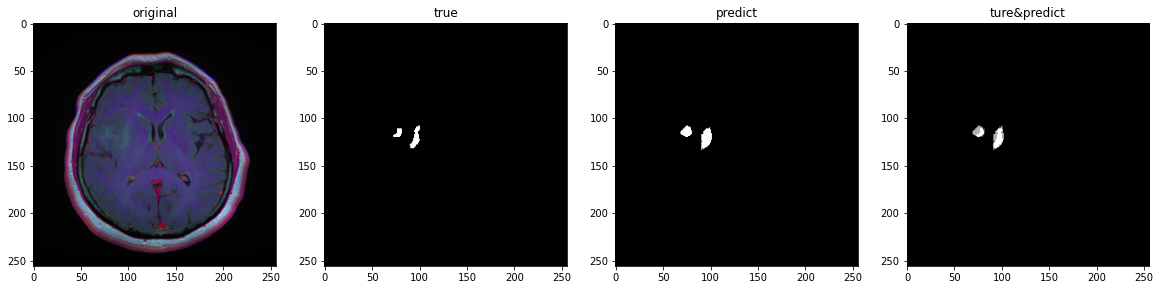

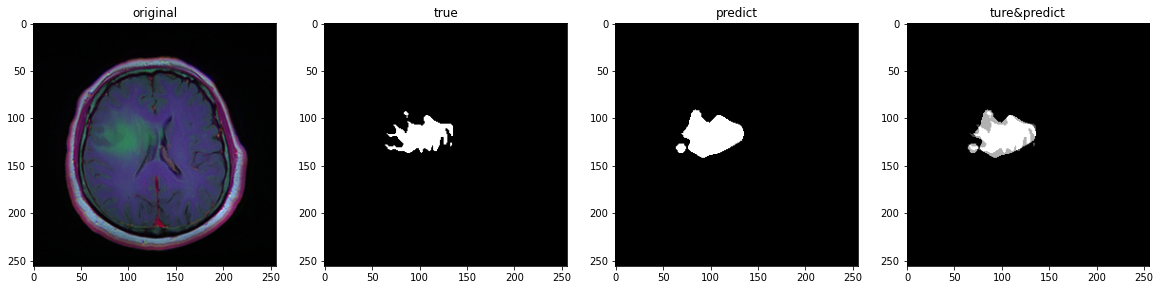

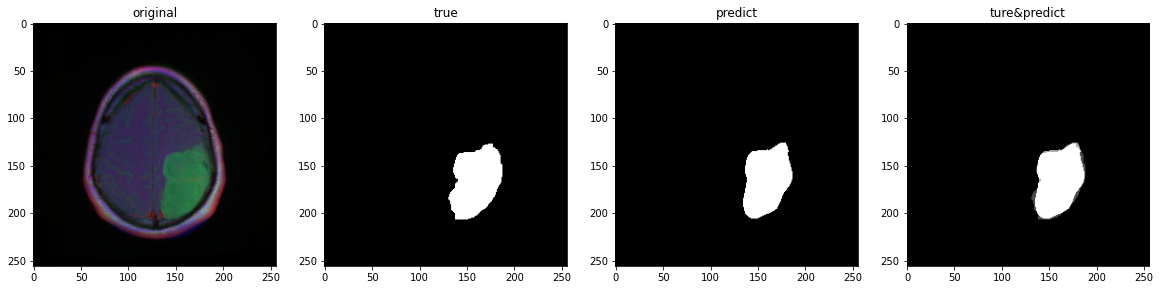

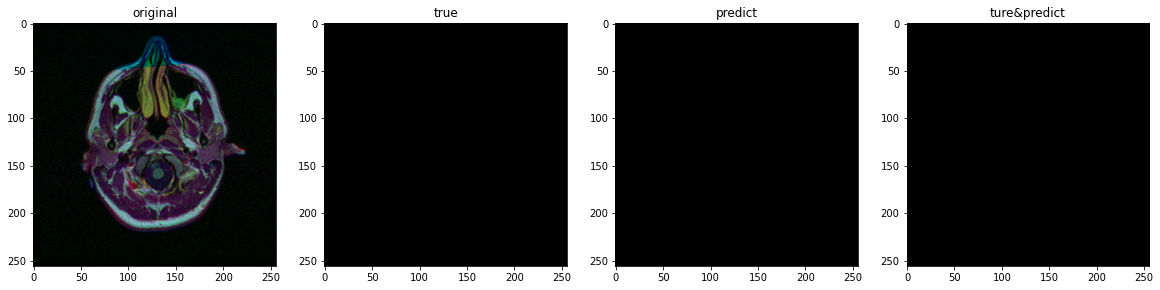

In [ ]:
for N in range(4):
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    img=cv2.imread(test_img[N])
    plt.title("original")
    plt.imshow(img)
    plt.subplot(1,4,2)
    plt.title("true")
    plt.imshow(true_pic[N])
    plt.subplot(1,4,3)
    plt.title("predict")
    plt.imshow(pre[N])
    plt.subplot(1,4,4)
    plt.title("ture&predict")
    plt.imshow(true_pic[N])
    plt.imshow(pre[N],alpha=0.7,cmap="jet")

In [ ]:
epoch = np.arange(1,21).reshape(20,1)

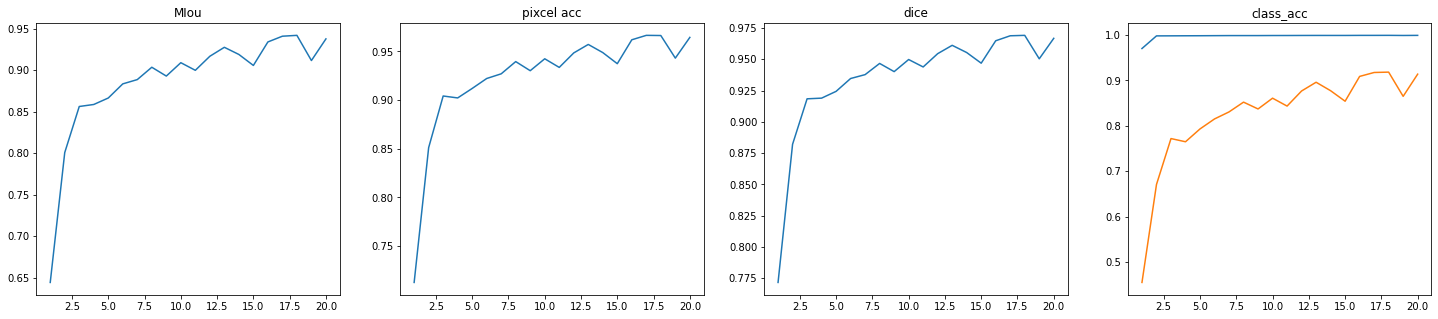

In [ ]:
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.plot(epoch,train_miou_epoch)
plt.title("MIou")
plt.subplot(1,4,2)
plt.plot(epoch,train_acc_epoch)
plt.title("pixcel acc")
plt.subplot(1,4,3)
plt.plot(epoch,train_dice_epoch)
plt.title("dice")
plt.subplot(1,4,4)
plt.plot(epoch,train_class_acc_epoch)
plt.title("class_acc")
plt.show()